Loading the Data

In [7]:
import pandas as pd
import numpy as np

In [8]:
# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_NIR_DIST_3b.csv")

In [53]:
print(df_0.head())

  prov_char country_char           wavenumber     11544     11540     11536  \
0       KAX           ID  ID-KAX-088-2401-001  0.290252  0.290122  0.290044   
1       KBX           ID  ID-KBX-068-2306-003  0.522845  0.522798  0.522826   
2       BBX           ID  ID-BBX-095-2401-004 -0.144108 -0.144008 -0.143893   
3       SUX           ID  ID-SUX-074-2311-001  0.333905  0.333777  0.333785   
4       SUX           ID  ID-SUX-073-2311-001  1.522433  1.521460  1.521133   

      11532     11528     11524     11520  ...      3964      3960      3956  \
0  0.290029  0.290042  0.289978  0.289851  ...  3.558086  3.542757  3.530849   
1  0.522669  0.522414  0.522217  0.522070  ...  3.680422  3.655416  3.629388   
2 -0.143777 -0.143686 -0.143667 -0.143678  ...  3.650478  3.623180  3.614590   
3  0.333700  0.333522  0.333453  0.333446  ...  3.601331  3.566453  3.539593   
4  1.521072  1.521494  1.522300  1.521840  ...  4.103365  4.125110  4.113971   

       3952  tgp_name  dgp_name  fgp_name  c

Selecting Regions of Interest

In [10]:
# Define the regions of interest
regions_of_interest = [
    (4641, 4681), (4867, 5510), (5657, 5826), (7057, 7097),
    (7169, 7209), (8238, 8278)
]

# Extract columns corresponding to the regions of interest
columns_to_focus = []
for start, end in regions_of_interest:
    columns_to_focus.extend([col for col in df_0.columns[4:-7] if start <= float(col) <= end])

# Create a new DataFrame with the selected regions
df_0_selected_regions = df_0[columns_to_focus]

# Combine the selected regions with the target column and other relevant columns
df_0_selected_regions = pd.concat([df_0[['thnoth_name', 'prov_char']], df_0_selected_regions], axis=1)

# Save the DataFrame for further processing
#df_0_selected_regions.to_csv('data/data file 2b/data_1.csv', index=False)


In [11]:
df_0_selected_regions.head()

,thnoth_name,prov_char,4680,4676,4672,4668,4664,4660,4656,4652,...,8276,8272,8268,8264,8260,8256,8252,8248,8244,8240
0,Non-Thai,KAX,1.145221,1.161998,1.183733,1.206279,1.221476,1.219369,1.195433,1.155057,...,0.693094,0.696532,0.699208,0.701041,0.702028,0.702149,0.701310,0.699461,0.696617,0.692720
1,Non-Thai,KBX,1.100158,1.117663,1.140348,1.163641,1.178847,1.175626,1.149462,1.106238,...,0.827193,0.830521,0.833110,0.834886,0.835800,0.835858,0.835008,0.833129,0.830211,0.826278
2,Non-Thai,BBX,0.873460,0.891096,0.914072,0.937998,0.954190,0.951890,0.926066,0.882441,...,0.370219,0.373736,0.376443,0.378311,0.379332,0.379466,0.378665,0.376875,0.374042,0.370139
3,Non-Thai,SUX,1.014767,1.031323,1.052854,1.075045,1.089551,1.086283,1.060706,1.018413,...,0.694977,0.698438,0.701122,0.702996,0.703988,0.704090,0.703278,0.701477,0.698633,0.694729
4,Non-Thai,SUX,1.520511,1.536409,1.557498,1.579159,1.592749,1.588327,1.561828,1.519022,...,1.606612,1.609559,1.611674,1.613343,1.614402,1.614270,1.612957,1.610735,1.607516,1.603303


FUNCTIONS

Baseline Correction

In [12]:
from scipy.signal import savgol_filter

# Function for baseline correction with dynamic window length
def baseline_correction(spectrum, default_window_length=15, polyorder=3):
    spectrum_length = len(spectrum)
    if spectrum_length < default_window_length:
        window_length = spectrum_length // 2 * 2 + 1  # Make window length odd and less than the size of the spectrum
    else:
        window_length = default_window_length
    baseline = savgol_filter(spectrum, window_length, polyorder, mode='nearest')
    corrected_spectrum = spectrum - baseline
    return corrected_spectrum

# Apply baseline correction
df_baseline_corrected_v0 = df_0_selected_regions.copy()
for col in columns_to_focus:
    df_baseline_corrected_v0[col] = baseline_correction(df_baseline_corrected_v0[col])

# Save the baseline corrected data
#df_baseline_corrected_v0.to_csv('data/data file 2b/data_1_bslcrct.csv', index=False)

SavGol Smoothing

In [13]:
# Function for Savitzky-Golay smoothing
def savitzky_golay_smoothing(spectrum, default_window_length=11, polyorder=2):
    window_length = min(default_window_length, len(spectrum) // 2 * 2 + 1)  # Make window length odd and less than or equal to the size of the spectrum
    if window_length < 3:  # Ensure window length is at least 3
        window_length = 3
    return savgol_filter(spectrum, window_length, polyorder, mode='nearest')  # Set mode to 'nearest'

# Apply smoothing
df_smoothed_v0 = df_baseline_corrected_v0.copy()
for col in columns_to_focus:
    df_smoothed_v0[col] = savitzky_golay_smoothing(df_smoothed_v0[col])

# Save the smoothed data
#df_smoothed_v0.to_csv('data/data file 2b/data_1_smoothed.csv', index=False)


Normalization

In [14]:
# Function for normalization (Min-Max scaling)
def min_max_normalization(spectrum):
    return (spectrum - np.min(spectrum)) / (np.max(spectrum) - np.min(spectrum))

# Apply normalization
df_normalized_v0 = df_smoothed_v0.copy()
for col in columns_to_focus:
    df_normalized_v0[col] = min_max_normalization(df_normalized_v0[col])

# Save the normalized data
#df_normalized_v0.to_csv('data/data file 2b/data_1_normalized.csv', index=False)


Derivatization (np.gradient)

In [15]:
# Calculate the first derivative using np.gradient
data_spectrum = df_normalized_v0.iloc[:, 2:].values
first_derivative_np = np.gradient(data_spectrum, axis=1)

# Calculate the second derivative using np.gradient
second_derivative_np = np.gradient(first_derivative_np, axis=1)

# Convert the results back to DataFrame
data_1_der_np = pd.DataFrame(first_derivative_np, columns=df_normalized_v0.columns[2:])
data_2_der_np = pd.DataFrame(second_derivative_np, columns=df_normalized_v0.columns[2:])

# Combine the first two columns from the original dataset with the np.gradient derivatives

# Extract the first two columns
first_two_columns = df_normalized_v0.iloc[:, :2]

# Combine the first two columns with the derivatives
data_1_der_combined = pd.concat([first_two_columns, data_1_der_np], axis=1)
data_2_der_combined = pd.concat([first_two_columns, data_2_der_np], axis=1)

# Export the combined data to CSV
#data_1_der_combined.to_csv('data/data file 2b/data_1_1_der.csv', index=False)
#data_2_der_combined.to_csv('data/data file 2b/data_1_2_der.csv', index=False)

Derivatization (SavGol)

In [16]:
# Extract the spectrum data
data_spectrum = df_normalized_v0.iloc[:, 2:].values

# Apply Savitzky-Golay filter for the first derivative
first_derivative_savgol = savgol_filter(data_spectrum, window_length=5, polyorder=2, deriv=1, axis=1)

# Apply Savitzky-Golay filter for the second derivative
second_derivative_savgol = savgol_filter(data_spectrum, window_length=5, polyorder=2, deriv=2, axis=1)

# Convert the results back to DataFrame
data_1_der_savgol = pd.DataFrame(first_derivative_savgol, columns=df_normalized_v0.columns[2:])
data_2_der_savgol = pd.DataFrame(second_derivative_savgol, columns=df_normalized_v0.columns[2:])

# Extract the first two columns
first_two_columns = df_normalized_v0.iloc[:, :2]

# Combine the first two columns with the Savitzky-Golay derivatives
data_1_der_savgol_combined = pd.concat([first_two_columns, data_1_der_savgol], axis=1)
data_2_der_savgol_combined = pd.concat([first_two_columns, data_2_der_savgol], axis=1)

# Export the combined data to CSV
#data_1_der_savgol_combined.to_csv('data/data file 2b/data_1_1_der_savgol.csv', index=False)
#data_2_der_savgol_combined.to_csv('data/data file 2b/data_1_2_der_savgol.csv', index=False)

SNV

In [17]:
def snv(spectrum):
    return (spectrum - np.mean(spectrum)) / np.std(spectrum)

# Apply SNV to the selected regions
df_snv = df_0_selected_regions.copy()
for col in columns_to_focus:
    df_snv[col] = snv(df_snv[col])

# Save the SNV data
#df_snv.to_csv('data/data file 2b/data_1_snv.csv', index=False)


Random Normal Variate (RNV)

In [18]:
def rnv(spectrum):
    random_noise = np.random.normal(0, np.std(spectrum), spectrum.shape)
    return spectrum + random_noise

# Apply RNV to the selected regions
df_rnv = df_0_selected_regions.copy()
for col in columns_to_focus:
    df_rnv[col] = rnv(df_rnv[col])

# Save the RNV data
#df_rnv.to_csv('data/data file 2b/data_1_rnv.csv', index=False)


Multiplicative Scatter Correction (MSC)

In [19]:
# Select only the spectral df_0_selected_regions columns (excluding 'thnoth_name', 'prov_char', and the last two columns)
spectral_df_0_selected_regions_columns = df_0_selected_regions.columns[2:]
spectral_df_0_selected_regions = df_0_selected_regions[spectral_df_0_selected_regions_columns]

# Calculate the mean spectrum across all samples
mean_spectrum = spectral_df_0_selected_regions.mean(axis=0)

# Perform Mean Centering (MSC)
msc_spectral_df_0_selected_regions = spectral_df_0_selected_regions - mean_spectrum

# Add back the non-spectral columns to the df_0_selected_regionsframe
msc_df_0_selected_regions = df_0_selected_regions[['thnoth_name', 'prov_char']].copy()
msc_df_0_selected_regions = pd.concat([msc_df_0_selected_regions, msc_spectral_df_0_selected_regions], axis=1)

# Save the MSC preprocessed df_0_selected_regions to a new CSV file
#msc_df_0_selected_regions.to_csv('data/data file 2b/data_1_msc.csv', index=False)

# Display the first few rows of the MSC preprocessed df_0_selected_regions
#print(msc_df_0_selected_regions.head())

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the target variable
target = 'thnoth_name'

# Ensure columns_to_focus are correctly identified
numeric_cols_df_0 = df_0_selected_regions.select_dtypes(include=[np.number]).columns.tolist()
columns_to_focus = numeric_cols_df_0  # Ensure columns are correctly selected

Step-by-Step Implementation for Classifiers Evaluation

In [21]:
# Load the smoothed dataset
df_1dernp_v00 = pd.read_csv('data/data file 2b/data_1_1_der.csv')

Define the Target Variable and Features

In [23]:
# Define the target_v00 variable and feature columns
target_v00 = 'thnoth_name'
features_v00 = df_1dernp_v00.columns.difference(['thnoth_name', 'prov_char'])
X = df_1dernp_v00[features_v00]
y = df_1dernp_v00[target_v00]
groups = df_1dernp_v00['prov_char']

In [24]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

Support Vector Machine (SVM)

In [26]:
# Standardize the features
scaler = StandardScaler()
X_scaled_svm = scaler.fit_transform(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the SVM classifier
svm = SVC(kernel='rbf', random_state=42)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
y_true_svm2_all = []
y_pred_svm2_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X_scaled_svm, y_encoded, groups):
    X_train, X_test = X_scaled_svm[train_index], X_scaled_svm[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    svm.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = svm.predict(X_test)
    
    # Store the prediction and actual value
    y_true_svm2_all.extend(y_test)
    y_pred_svm2_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_true_svm2_all, y_pred_svm2_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_svm1_logo = classification_report(y_true_svm2_all, y_pred_svm2_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV SVM Model Classification Report")
print(classification_report(y_true_svm2_all, y_pred_svm2_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_svm2_all, y_pred_svm2_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_svm1_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.8414893617021276
Leave-One-Group-Out CV SVM Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.93      0.74      0.82       470
        Thai       0.78      0.94      0.86       470

    accuracy                           0.84       940
   macro avg       0.86      0.84      0.84       940
weighted avg       0.86      0.84      0.84       940

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       347   123
Thai            26   444
Class: Non-Thai
precision: 0.9302949061662198
recall: 0.7382978723404255
f1-score: 0.8232502965599051
support: 470.0

Class: Thai
precision: 0.783068783068783
recall: 0.9446808510638298
f1-score: 0.8563162970106075
support: 470.0

accuracy: 0.8414893617021276

Class: macro avg
precision: 0.8566818446175014
recall: 0.8414893617021277
f1-score: 0.8397832967852563
support: 940.0

Class: weighted avg
precision: 0.8566818446175014
recall: 0.8414893617021276
f

Random Forest (RF) classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Classification and evaluation function using LOGO-CV with detailed metrics
def classify_and_evaluate_logo_cv_detailed(df, columns):
    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(df[target])
    
    # Define features
    X = df[columns]
    
    # Initialize the classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Initialize LOGO-CV
    logo = LeaveOneGroupOut()
    groups = df['prov_char']
    
    # Arrays to store results
    y_true_all = []
    y_pred_all = []
    
    # Perform LOGO-CV
    for train_idx, test_idx in logo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict and store results
        y_pred = model.predict(X_test)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    # Calculate overall metrics
    overall_accuracy = accuracy_score(y_true_all, y_pred_all)
    precision = precision_score(y_true_all, y_pred_all, average=None)
    recall = recall_score(y_true_all, y_pred_all, average=None)
    f1 = f1_score(y_true_all, y_pred_all, average=None)
    conf_matrix = confusion_matrix(y_true_all, y_pred_all)
    
    # Generate classification report
    report = classification_report(y_true_all, y_pred_all, target_names=le.classes_, output_dict=True)
    
    # Print the results
    print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')
    print("Leave-One-Group-Out CV Random Forest Model Classification Report")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))
    
    # Print the confusion matrix in text format
    conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
    print("Confusion Matrix:")
    print(conf_matrix_df)
    
    # Print the detailed results
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class: {class_name}")
            for metric_name, score in metrics.items():
                print(f"{metric_name}: {score}")
        else:
            print(f"{class_name}: {metrics}")
        print()
    
    # Return confusion matrix for presentation
    return conf_matrix

print("LOGO-CV Evaluation for 1-Derivative Spectroscopy:")
conf_matrix_1_derivative_v03 = classify_and_evaluate_logo_cv_detailed(df_1dernp_v00, columns_to_focus)

LOGO-CV Evaluation for 1-Derivative Spectroscopy:
Leave-One-Group-Out CV - Overall Test Accuracy: 0.8021276595744681
Leave-One-Group-Out CV Random Forest Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.80      0.80      0.80       470
        Thai       0.80      0.81      0.80       470

    accuracy                           0.80       940
   macro avg       0.80      0.80      0.80       940
weighted avg       0.80      0.80      0.80       940

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       375    95
Thai            91   379
Class: Non-Thai
precision: 0.8047210300429185
recall: 0.7978723404255319
f1-score: 0.8012820512820513
support: 470.0

Class: Thai
precision: 0.79957805907173
recall: 0.8063829787234043
f1-score: 0.8029661016949152
support: 470.0

accuracy: 0.8021276595744681

Class: macro avg
precision: 0.8021495445573242
recall: 0.8021276595744681
f1-score: 0.8021240764884833
support: 940.0

Class: weighted avg

In [32]:
# Classification and evaluation function using LOGO-CV with detailed metrics
def classify_and_evaluate_logo_cv_detailed(df, columns):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import LeaveOneGroupOut
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(df[target])
    
    # Define features
    X = df[columns]
    
    # Initialize the classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Initialize LOGO-CV
    logo = LeaveOneGroupOut()
    groups = df['prov_char']
    
    # Arrays to store results
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    all_y_test = []
    all_y_pred = []
    
    # Perform LOGO-CV
    for train_idx, test_idx in logo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)
        
    # Calculate overall metrics
    mean_accuracy = np.mean(accuracies)
    precision = precision_score(all_y_test, all_y_pred, average=None)
    recall = recall_score(all_y_test, all_y_pred, average=None)
    f1 = f1_score(all_y_test, all_y_pred, average=None)
    conf_matrix = confusion_matrix(all_y_test, all_y_pred)
    
    # Print the results
    print(f'Mean Accuracy: {mean_accuracy}')
    print(f'Precision per class: {precision}')
    print(f'Recall per class: {recall}')
    print(f'F1-score per class: {f1}')
    
    # Return confusion matrix for presentation
    return conf_matrix

print("LOGO-CV Evaluation for 1-Derivative Spectroscopy:")
conf_matrix_1_derivative_v03 = classify_and_evaluate_logo_cv_detailed(df_1dernp_v00, columns_to_focus)

LOGO-CV Evaluation for 1-Derivative Spectroscopy:
Mean Accuracy: 0.8545845339928044
Precision per class: [0.80472103 0.79957806]
Recall per class: [0.79787234 0.80638298]
F1-score per class: [0.80128205 0.8029661 ]


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Classification and evaluation function using LOGO-CV with detailed metrics
def classify_and_evaluate_logo_cv_detailed(df, columns):
    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(df[target])
    
    # Define features
    X = df[columns]
    
    # Initialize the classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Initialize LOGO-CV
    logo = LeaveOneGroupOut()
    groups = df['prov_char']
    
    # Arrays to store results
    accuracies = []
    y_true_all = []
    y_pred_all = []
    
    # Perform LOGO-CV
    for train_idx, test_idx in logo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict and store results
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    # Calculate overall metrics
    overall_accuracy = np.mean(accuracies)
    precision = precision_score(y_true_all, y_pred_all, average=None)
    recall = recall_score(y_true_all, y_pred_all, average=None)
    f1 = f1_score(y_true_all, y_pred_all, average=None)
    conf_matrix = confusion_matrix(y_true_all, y_pred_all)
    
    # Generate classification report
    report = classification_report(y_true_all, y_pred_all, target_names=le.classes_, output_dict=True)
    
    # Print the results
    print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')
    print("Leave-One-Group-Out CV Random Forest Model Classification Report")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))
    
    # Print the confusion matrix in text format
    conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
    print("Confusion Matrix:")
    print(conf_matrix_df)
    
    # Print the detailed results
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class: {class_name}")
            for metric_name, score in metrics.items():
                print(f"{metric_name}: {score}")
        else:
            print(f"{class_name}: {metrics}")
        print()
    
    # Return confusion matrix for presentation
    return conf_matrix

print("LOGO-CV Evaluation for 1-Derivative Spectroscopy:")
conf_matrix_1_derivative_v03 = classify_and_evaluate_logo_cv_detailed(df_1dernp_v00, columns_to_focus)

LOGO-CV Evaluation for 1-Derivative Spectroscopy:
Leave-One-Group-Out CV - Overall Test Accuracy: 0.8379168223327018
Leave-One-Group-Out CV Random Forest Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.80      0.79      0.80       470
        Thai       0.79      0.80      0.80       470

    accuracy                           0.80       940
   macro avg       0.80      0.80      0.80       940
weighted avg       0.80      0.80      0.80       940

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       372    98
Thai            93   377
Class: Non-Thai
precision: 0.8
recall: 0.7914893617021277
f1-score: 0.7957219251336899
support: 470.0

Class: Thai
precision: 0.7936842105263158
recall: 0.8021276595744681
f1-score: 0.7978835978835979
support: 470.0

accuracy: 0.7968085106382978

Class: macro avg
precision: 0.7968421052631579
recall: 0.7968085106382978
f1-score: 0.7968027615086439
support: 940.0

Class: weighted avg
precision: 0

In [49]:
# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies = []
y_true_rf3_all = []
y_pred_rf3_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    rf.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = rf.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual value
    y_true_rf3_all.extend(y_test)
    y_pred_rf3_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = np.mean(accuracies) #accuracy_score(y_true_rf3_all, y_pred_rf3_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_rf_logo = classification_report(y_true_rf3_all, y_pred_rf3_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV Random Forest Model Classification Report")
print(classification_report(y_true_rf3_all, y_pred_rf3_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_rf3_all, y_pred_rf3_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_rf_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.8379168223327018
Leave-One-Group-Out CV Random Forest Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.80      0.79      0.80       470
        Thai       0.79      0.80      0.80       470

    accuracy                           0.80       940
   macro avg       0.80      0.80      0.80       940
weighted avg       0.80      0.80      0.80       940

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       372    98
Thai            93   377
Class: Non-Thai
precision: 0.8
recall: 0.7914893617021277
f1-score: 0.7957219251336899
support: 470.0

Class: Thai
precision: 0.7936842105263158
recall: 0.8021276595744681
f1-score: 0.7978835978835979
support: 470.0

accuracy: 0.7968085106382978

Class: macro avg
precision: 0.7968421052631579
recall: 0.7968085106382978
f1-score: 0.7968027615086439
support: 940.0

Class: weighted avg
precision: 0.7968421052631579
recall: 0.7968085106382978
f1-sc

Extra Trees (ET) classifier

In [34]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the Extra Trees classifier
et = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
y_true_et_all = []
y_pred_et_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    et.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = et.predict(X_test)
    
    # Store the prediction and actual value
    y_true_et_all.extend(y_test)
    y_pred_et_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_true_et_all, y_pred_et_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_et_logo = classification_report(y_true_et_all, y_pred_et_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV Extra Trees Model Classification Report")
print(classification_report(y_true_et_all, y_pred_et_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_et_all, y_pred_et_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_et_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.8095744680851064
Leave-One-Group-Out CV Extra Trees Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.84      0.77      0.80       470
        Thai       0.78      0.85      0.82       470

    accuracy                           0.81       940
   macro avg       0.81      0.81      0.81       940
weighted avg       0.81      0.81      0.81       940

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       360   110
Thai            69   401
Class: Non-Thai
precision: 0.8391608391608392
recall: 0.7659574468085106
f1-score: 0.8008898776418243
support: 470.0

Class: Thai
precision: 0.7847358121330724
recall: 0.8531914893617021
f1-score: 0.817533129459735
support: 470.0

accuracy: 0.8095744680851064

Class: macro avg
precision: 0.8119483256469557
recall: 0.8095744680851064
f1-score: 0.8092115035507796
support: 940.0

Class: weighted avg
precision: 0.8119483256469558
recall: 0.8095744680

k-Nearest Neighbors (kNN)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
y_true_knn_all = []
y_pred_knn_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = knn.predict(X_test)
    
    # Store the prediction and actual value
    y_true_knn_all.extend(y_test)
    y_pred_knn_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_true_knn_all, y_pred_knn_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_knn_logo = classification_report(y_true_knn_all, y_pred_knn_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV kNN Model Classification Report")
print(classification_report(y_true_knn_all, y_pred_knn_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_knn_all, y_pred_knn_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_knn_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.5893617021276596
Leave-One-Group-Out CV kNN Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.69      0.32      0.44       470
        Thai       0.56      0.86      0.68       470

    accuracy                           0.59       940
   macro avg       0.63      0.59      0.56       940
weighted avg       0.63      0.59      0.56       940

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       150   320
Thai            66   404
Class: Non-Thai
precision: 0.6944444444444444
recall: 0.3191489361702128
f1-score: 0.43731778425655976
support: 470.0

Class: Thai
precision: 0.5580110497237569
recall: 0.8595744680851064
f1-score: 0.6767169179229481
support: 470.0

accuracy: 0.5893617021276596

Class: macro avg
precision: 0.6262277470841007
recall: 0.5893617021276596
f1-score: 0.5570173510897539
support: 940.0

Class: weighted avg
precision: 0.6262277470841006
recall: 0.5893617021276596

In [41]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Standardize the features after SNV transformation
scaler = StandardScaler()
X_scaled_knn = scaler.fit_transform(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
y_true_knn_all = []
y_pred_knn_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X_scaled_knn, y_encoded, groups):
    X_train, X_test = X_scaled_knn[train_index], X_scaled_knn[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = knn.predict(X_test)
    
    # Store the prediction and actual value
    y_true_knn_all.extend(y_test)
    y_pred_knn_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_true_knn_all, y_pred_knn_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_knn_logo = classification_report(y_true_knn_all, y_pred_knn_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV kNN Model Classification Report")
print(classification_report(y_true_knn_all, y_pred_knn_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_knn_all, y_pred_knn_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_knn_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.6957446808510638
Leave-One-Group-Out CV kNN Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.90      0.44      0.59       470
        Thai       0.63      0.95      0.76       470

    accuracy                           0.70       940
   macro avg       0.76      0.70      0.67       940
weighted avg       0.76      0.70      0.67       940

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       208   262
Thai            24   446
Class: Non-Thai
precision: 0.896551724137931
recall: 0.4425531914893617
f1-score: 0.5925925925925926
support: 470.0

Class: Thai
precision: 0.6299435028248588
recall: 0.948936170212766
f1-score: 0.7572156196943973
support: 470.0

accuracy: 0.6957446808510638

Class: macro avg
precision: 0.7632476134813949
recall: 0.6957446808510639
f1-score: 0.6749041061434949
support: 940.0

Class: weighted avg
precision: 0.7632476134813949
recall: 0.6957446808510638
f1

Gradient Boosting Classifier (GBC)

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
model_gbc = GradientBoostingClassifier(random_state=42)

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies_gbc = []
y_true_all_gbc = []
y_pred_all_gbc = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    model_gbc.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = model_gbc.predict(X_test)
    
    # Calculate and store the accuracy
    accuracies_gbc.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual values
    y_true_all_gbc.extend(y_test)
    y_pred_all_gbc.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy_gbc = accuracy_score(y_true_all_gbc, y_pred_all_gbc)

print(f'Leave-One-Group-Out CV - Average Test Accuracy: {overall_accuracy_gbc}')
print("Leave-One-Group-Out CV GBC Model Classification Report")
report_gbc_logo = classification_report(y_true_all_gbc, y_pred_all_gbc, target_names=le.classes_, output_dict=True)
print(classification_report(y_true_all_gbc, y_pred_all_gbc, target_names=le.classes_))

# Generate and display the confusion matrix
cm_logo_gbc = confusion_matrix(y_true_all_gbc, y_pred_all_gbc)
df_cm_gbc = pd.DataFrame(cm_logo_gbc, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(df_cm_gbc)

# Display the detailed results
for class_name, metrics in report_gbc_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Average Test Accuracy: 0.8031914893617021
Leave-One-Group-Out CV GBC Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.84      0.74      0.79       470
        Thai       0.77      0.86      0.81       470

    accuracy                           0.80       940
   macro avg       0.81      0.80      0.80       940
weighted avg       0.81      0.80      0.80       940

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       350   120
Thai            65   405
Class: Non-Thai
precision: 0.8433734939759037
recall: 0.7446808510638298
f1-score: 0.7909604519774012
support: 470.0

Class: Thai
precision: 0.7714285714285715
recall: 0.8617021276595744
f1-score: 0.8140703517587939
support: 470.0

accuracy: 0.8031914893617021

Class: macro avg
precision: 0.8074010327022376
recall: 0.803191489361702
f1-score: 0.8025154018680976
support: 940.0

Class: weighted avg
precision: 0.8074010327022376
recall: 0.8031914893617021
f

LightGBM (LGBM) Classifier

In [43]:
import lightgbm as lgb
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the LightGBM Classifier
model_lgbm = lgb.LGBMClassifier(random_state=42)

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies_lgbm = []
y_true_all_lgbm = []
y_pred_all_lgbm = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    model_lgbm.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = model_lgbm.predict(X_test)
    
    # Calculate and store the accuracy
    accuracies_lgbm.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual values
    y_true_all_lgbm.extend(y_test)
    y_pred_all_lgbm.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy_lgbm = accuracy_score(y_true_all_lgbm, y_pred_all_lgbm)

print(f'Leave-One-Group-Out CV - Average Test Accuracy: {overall_accuracy_lgbm}')
print("Leave-One-Group-Out CV LGBM Model Classification Report")
report_lgbm_logo = classification_report(y_true_all_lgbm, y_pred_all_lgbm, target_names=le.classes_, output_dict=True)
print(classification_report(y_true_all_lgbm, y_pred_all_lgbm, target_names=le.classes_))

# Generate and display the confusion matrix
cm_logo_lgbm = confusion_matrix(y_true_all_lgbm, y_pred_all_lgbm)
df_cm_lgbm = pd.DataFrame(cm_logo_lgbm, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(df_cm_lgbm)

# Display the detailed results
for class_name, metrics in report_lgbm_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


[LightGBM] [Info] Number of positive: 470, number of negative: 425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61960
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 243
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525140 -> initscore=0.100644
[LightGBM] [Info] Start training from score 0.100644
[LightGBM] [Info] Number of positive: 457, number of negative: 470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61960
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 243
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492988 -> initscore=-0.028049
[LightGBM] [Info] Start training from score -0.028049
[LightGBM] [Info] Numb

Linear Discriminant Analysis (LDA) classifier

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the LDA Classifier
model_lda = LinearDiscriminantAnalysis()

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies_lda = []
y_true_all_ldar = []
y_pred_all_ldar = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    model_lda.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = model_lda.predict(X_test)
    
    # Calculate and store the accuracy
    accuracies_lda.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual values
    y_true_all_ldar.extend(y_test)
    y_pred_all_ldar.extend(y_test_pred)

# Reverse the predicted classes
y_pred_all_ldar_reversed = [1 - y for y in y_pred_all_ldar]

# Calculate the overall accuracy for the reversed predictions
overall_accuracy_lda_reversed = accuracy_score(y_true_all_ldar, y_pred_all_ldar_reversed)

print(f'Leave-One-Group-Out CV - Average Test Accuracy (Reversed Classes): {overall_accuracy_lda_reversed}')
print("Leave-One-Group-Out CV LDA Model Classification Report (Reversed Classes)")
report_lda_logo_reversed = classification_report(y_true_all_ldar, y_pred_all_ldar_reversed, target_names=le.classes_, output_dict=True)
print(classification_report(y_true_all_ldar, y_pred_all_ldar_reversed, target_names=le.classes_))

# Generate and display the confusion matrix for the reversed predictions
cm_logo_lda_reversed = confusion_matrix(y_true_all_ldar, y_pred_all_ldar_reversed)
df_cm_lda_reversed = pd.DataFrame(cm_logo_lda_reversed, index=le.classes_, columns=le.classes_)
print("Confusion Matrix (Reversed Classes):")
print(df_cm_lda_reversed)

# Display the detailed results for the reversed predictions
for class_name, metrics in report_lda_logo_reversed.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Average Test Accuracy (Reversed Classes): 0.8776595744680851
Leave-One-Group-Out CV LDA Model Classification Report (Reversed Classes)
              precision    recall  f1-score   support

    Non-Thai       0.90      0.85      0.87       470
        Thai       0.86      0.90      0.88       470

    accuracy                           0.88       940
   macro avg       0.88      0.88      0.88       940
weighted avg       0.88      0.88      0.88       940

Confusion Matrix (Reversed Classes):
          Non-Thai  Thai
Non-Thai       400    70
Thai            45   425
Class: Non-Thai
precision: 0.898876404494382
recall: 0.851063829787234
f1-score: 0.8743169398907104
support: 470.0

Class: Thai
precision: 0.8585858585858586
recall: 0.9042553191489362
f1-score: 0.8808290155440415
support: 470.0

accuracy: 0.8776595744680851

Class: macro avg
precision: 0.8787311315401203
recall: 0.8776595744680851
f1-score: 0.877572977717376
support: 940.0

Class: weighted avg
pre

Logistic Regression classifier

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Initialize Logistic Regression model with a different solver
logreg_model = LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
test_accuracies_logreg = []
y_true_all_logreg = []
y_pred_all_logreg = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    logreg_model.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = logreg_model.predict(X_test)
    
    # Calculate and store test accuracies
    test_accuracies_logreg.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual value
    y_true_all_logreg.extend(y_test)
    y_pred_all_logreg.extend(y_test_pred)

# Flip the predictions
y_pred_lg_flipped = ['Non-Thai' if pred == 'Thai' else 'Thai' for pred in y_pred_all_logreg]

# Generate the classification report for the flipped predictions
report_logreg_flipped = classification_report(y_true_all_logreg, y_pred_lg_flipped, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV Logistic Regression Model (Flipped) Classification Report")
print(classification_report(y_true_all_logreg, y_pred_lg_flipped, target_names=le.classes_))

# Generate and display the confusion matrix for the flipped predictions
cm_logreg_flipped = confusion_matrix(y_true_all_logreg, y_pred_lg_flipped)
df_cm_logreg_flipped = pd.DataFrame(cm_logreg_flipped, index=le.classes_, columns=le.classes_)
print("Confusion Matrix (Flipped):")
print(df_cm_logreg_flipped)

# Display the detailed results for the flipped predictions
for class_name, metrics in report_logreg_flipped.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV Logistic Regression Model (Flipped) Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.92      0.88      0.90       470
        Thai       0.89      0.93      0.91       470

    accuracy                           0.90       940
   macro avg       0.90      0.90      0.90       940
weighted avg       0.90      0.90      0.90       940

Confusion Matrix (Flipped):
          Non-Thai  Thai
Non-Thai       415    55
Thai            35   435
Class: Non-Thai
precision: 0.9222222222222223
recall: 0.8829787234042553
f1-score: 0.9021739130434783
support: 470.0

Class: Thai
precision: 0.8877551020408163
recall: 0.925531914893617
f1-score: 0.90625
support: 470.0

accuracy: 0.9042553191489362

Class: macro avg
precision: 0.9049886621315193
recall: 0.9042553191489362
f1-score: 0.9042119565217391
support: 940.0

Class: weighted avg
precision: 0.9049886621315193
recall: 0.9042553191489362
f1-score: 0.9042119565217391
support: 940.0

Classification Report

In [50]:
from sklearn.metrics import classification_report

# Assuming you have these classification reports stored
# classification_report_rf = ...
# classification_report_svm = ...
# classification_report_et = ...
# classification_report_knn = ...
# classification_report_gbc = ...
# classification_report_lgbm = ...
# classification_report_lda = ...
# classification_report_logreg = ...

# Function to display classification report
def display_classification_report(report, model_name):
    print(f"Classification Report for {model_name}")
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class: {label}")
            for metric_name, score in metrics.items():
                print(f"{metric_name}: {score}")
        else:
            print(f"{label}: {metrics}")
        print()

# Call the function for each classifier
display_classification_report(report_rf_logo, "Random Forest")
display_classification_report(report_svm1_logo, "SVM")
display_classification_report(report_et_logo, "Extra Trees")
display_classification_report(report_knn_logo, "k-Nearest Neighbors")
display_classification_report(report_gbc_logo, "Gradient Boosting Classifier")
display_classification_report(report_lgbm_logo, "LightGBM")
display_classification_report(report_lda_logo_reversed, "Linear Discriminant Analysis")
display_classification_report(report_logreg_flipped, "Logistic Regression")


Classification Report for Random Forest
Class: Non-Thai
precision: 0.8
recall: 0.7914893617021277
f1-score: 0.7957219251336899
support: 470.0

Class: Thai
precision: 0.7936842105263158
recall: 0.8021276595744681
f1-score: 0.7978835978835979
support: 470.0

accuracy: 0.7968085106382978

Class: macro avg
precision: 0.7968421052631579
recall: 0.7968085106382978
f1-score: 0.7968027615086439
support: 940.0

Class: weighted avg
precision: 0.7968421052631579
recall: 0.7968085106382978
f1-score: 0.7968027615086438
support: 940.0

Classification Report for SVM
Class: Non-Thai
precision: 0.9302949061662198
recall: 0.7382978723404255
f1-score: 0.8232502965599051
support: 470.0

Class: Thai
precision: 0.783068783068783
recall: 0.9446808510638298
f1-score: 0.8563162970106075
support: 470.0

accuracy: 0.8414893617021276

Class: macro avg
precision: 0.8566818446175014
recall: 0.8414893617021277
f1-score: 0.8397832967852563
support: 940.0

Class: weighted avg
precision: 0.8566818446175014
recall: 0.84

ConfusionMatrixDisplay

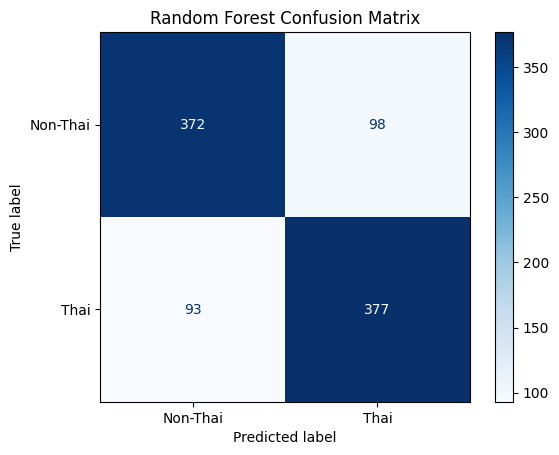

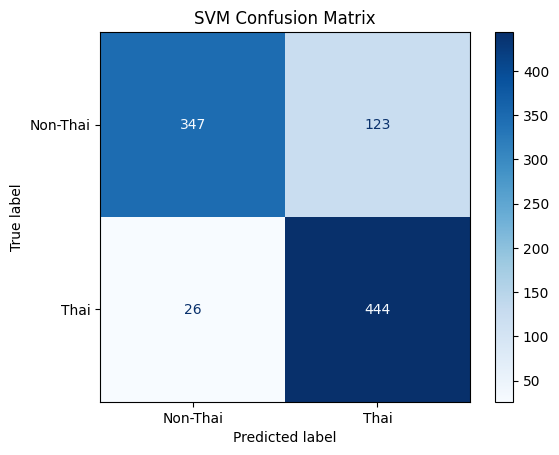

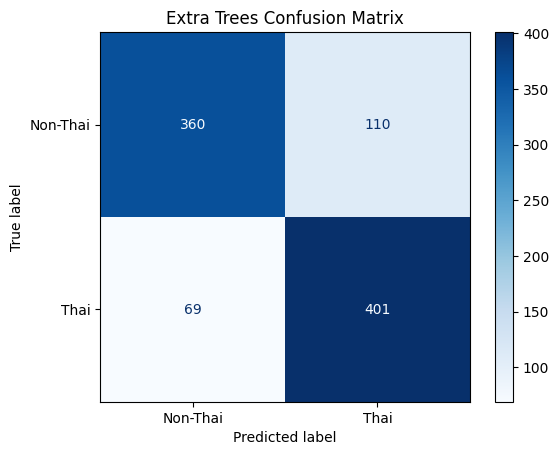

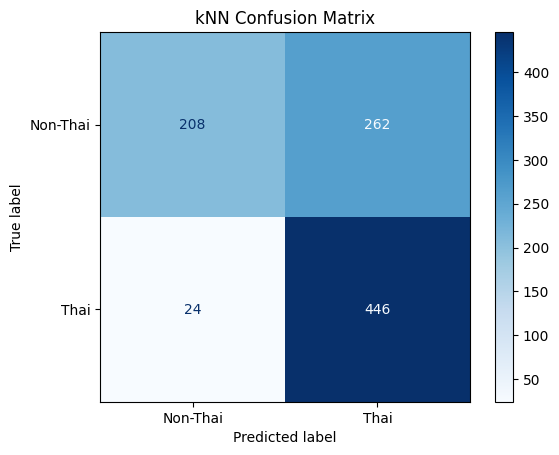

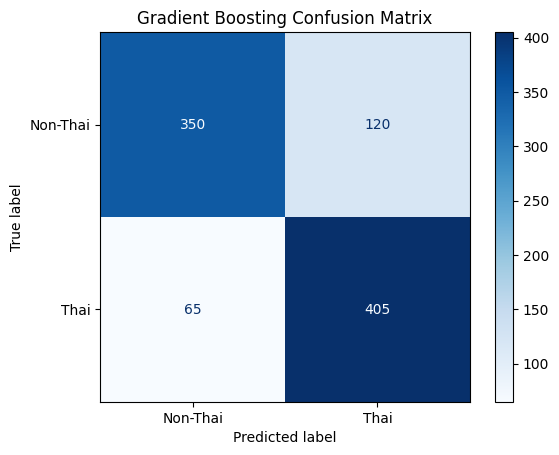

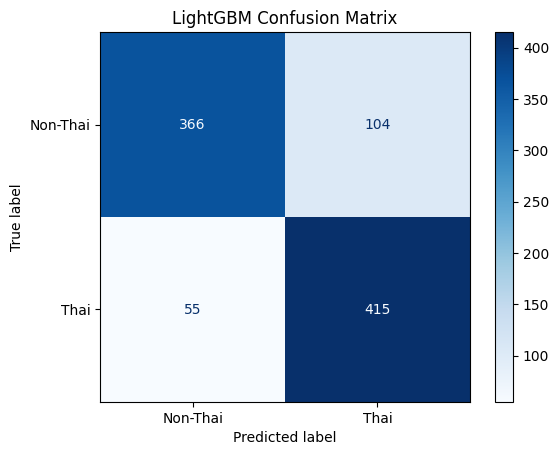

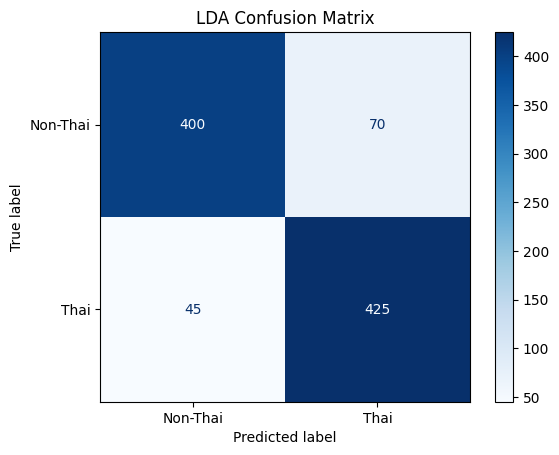

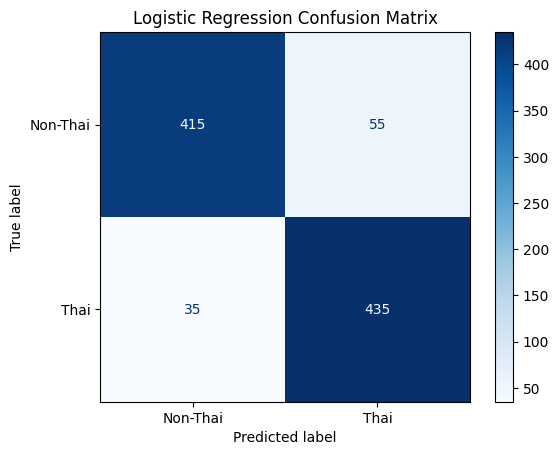

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have the true labels and predictions for each classifier stored in the following variables:
# y_true_rf, y_pred_rf
# y_true_svm, y_pred_svm
# y_true_et, y_pred_et
# y_true_knn, y_pred_knn
# y_true_gbc, y_pred_gbc
# y_true_lgbm, y_pred_lgbm
# y_true_lda, y_pred_lda
# y_true_logreg, y_pred_logreg

# y_true_rf2_all, y_pred_rf2_all
# y_true_svm2_all,  y_pred_svm2_all
# y_true_et_all, y_pred_et_all
# y_true_knn_all, y_pred_knn_all
# y_true_all_gbc, y_pred_all_gbc
# y_true_all_lgbm, y_pred_all_lgbm
# y_true_all_ldar, y_pred_all_ldar_reversed
# y_true_all_logreg, y_pred_lg_flipped

# Define the class labels
class_labels = le.classes_

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Display confusion matrices for each classifier
display_confusion_matrix(y_true_rf2_all, y_pred_rf2_all, 'Random Forest Confusion Matrix')
display_confusion_matrix(y_true_svm2_all,  y_pred_svm2_all, 'SVM Confusion Matrix')
display_confusion_matrix(y_true_et_all, y_pred_et_all, 'Extra Trees Confusion Matrix')
display_confusion_matrix(y_true_knn_all, y_pred_knn_all, 'kNN Confusion Matrix')
display_confusion_matrix(y_true_all_gbc, y_pred_all_gbc, 'Gradient Boosting Confusion Matrix')
display_confusion_matrix(y_true_all_lgbm, y_pred_all_lgbm, 'LightGBM Confusion Matrix')
display_confusion_matrix(y_true_all_ldar, y_pred_all_ldar_reversed, 'LDA Confusion Matrix')
display_confusion_matrix(y_true_all_logreg, y_pred_lg_flipped, 'Logistic Regression Confusion Matrix')


Displaying Confusion Matrices as Text Tables

In [52]:
# Function to display confusion matrix as a text table
def display_confusion_matrix_text(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    print(title)
    print(df_cm)
    print()

# Display confusion matrices for each classifier as text tables
display_confusion_matrix_text(y_true_rf2_all, y_pred_rf2_all, 'Random Forest Confusion Matrix')
display_confusion_matrix_text(y_true_svm2_all,  y_pred_svm2_all, 'SVM Confusion Matrix')
display_confusion_matrix_text(y_true_et_all, y_pred_et_all, 'Extra Trees Confusion Matrix')
display_confusion_matrix_text(y_true_knn_all, y_pred_knn_all, 'kNN Confusion Matrix')
display_confusion_matrix_text(y_true_all_gbc, y_pred_all_gbc, 'Gradient Boosting Confusion Matrix')
display_confusion_matrix_text(y_true_all_lgbm, y_pred_all_lgbm, 'LightGBM Confusion Matrix')
display_confusion_matrix_text(y_true_all_ldar, y_pred_all_ldar_reversed, 'LDA Confusion Matrix')
display_confusion_matrix_text(y_true_all_logreg, y_pred_lg_flipped, 'Logistic Regression Confusion Matrix')


Random Forest Confusion Matrix
          Non-Thai  Thai
Non-Thai       372    98
Thai            93   377

SVM Confusion Matrix
          Non-Thai  Thai
Non-Thai       347   123
Thai            26   444

Extra Trees Confusion Matrix
          Non-Thai  Thai
Non-Thai       360   110
Thai            69   401

kNN Confusion Matrix
          Non-Thai  Thai
Non-Thai       208   262
Thai            24   446

Gradient Boosting Confusion Matrix
          Non-Thai  Thai
Non-Thai       350   120
Thai            65   405

LightGBM Confusion Matrix
          Non-Thai  Thai
Non-Thai       366   104
Thai            55   415

LDA Confusion Matrix
          Non-Thai  Thai
Non-Thai       400    70
Thai            45   425

Logistic Regression Confusion Matrix
          Non-Thai  Thai
Non-Thai       415    55
Thai            35   435

